<a href="https://colab.research.google.com/github/osram90/whisper/blob/main/Proyecto1Dilatado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Actividad Proyecto Dilatado

In [ ]:
# @title Cargar video y Reproducirlo
from google.colab import files

uploaded = files.upload()
video_file_name = next(iter(uploaded))



Saving framesn.zip to framesn (1).zip


In [ ]:
# @title Reproducir video

from IPython.display import HTML
from base64 import b64encode

# Asume que 'video_file_name' contiene el nombre del archivo de video que subiste
video_path = video_file_name

# Cargar el video y codificarlo en base64
with open(video_path, 'rb') as f:
    video_data = b64encode(f.read()).decode()

# Mostrar el video en loop
HTML(f"""
<video width=400 controls loop>
    <source src="data:video/mp4;base64,{video_data}" type="video/mp4">
</video>
""")


Exception: Moviepy: ImageSequenceClip requires all images to be the same size

In [ ]:
from moviepy.editor import VideoFileClip

# Asumiendo que 'video_path' es la ruta a tu archivo de video
clip = VideoFileClip(video_path)
fps = clip.fps  # Obtiene la tasa de frames por segundo del video
print(f"FPS del video: {fps}")


FPS del video: 30.0


In [ ]:
%%capture
# @title Instala paquete para extraer los fotogramas

!pip install moviepy base64

In [ ]:

# @title Instala paquete para reproducir videos

!pip install ffmpeg-python

In [ ]:
# @title Extracción de Frames del video
#@title Run the extractor
#@markdown **Important:** Press the **▶** button once to initialise the tool before using this tool.

!pip install ffmpeg-python

import ipywidgets as widgets
from IPython.display import display, display_markdown, clear_output, Markdown
from typing import NamedTuple
import ffmpeg

from pathlib import Path
import os
from typing import List

import subprocess

clear_output()

# all the video file formats supported by ffmpeg - https://ffmpeg.org/ffmpeg-formats.html
video_extensions = list(map(lambda s: s.strip(), "mov, mp4, m4a, 3gp, 3g2, mj2, psp, m4b, ism, ismv, isma, f4v, avi, flv, mjpg, mjpeg".split(",")))

# Define the core functions of the tool

class UserInput(NamedTuple):
  video_path: str
  sampling_method: str
  sample_rate: int
  output_dir: str
  extract_frames: bool
  extract_audio: bool

def get_video_paths(video_path) -> List[Path]:
  video_file_paths: List[Path] = []
  if video_path:
    if os.path.isfile(video_path) and os.path.exists(video_path):
      video_file_paths.append(Path(video_path))
    else:
      video_dir = Path(video_path)
      if video_dir.is_dir() and video_dir.exists():
        for dir_child in video_dir.iterdir():
          if dir_child.is_file() and dir_child.exists() \
              and dir_child.suffix.lower().replace(".", "") in video_extensions:
            video_file_paths.append(dir_child)
    return video_file_paths

def get_video_stream_info(video_filename):
  probe = ffmpeg.probe(video_filename)
  video_streams = [s for s in probe["streams"] if s["codec_type"] == "video"]
  return video_streams[0] if len(video_streams) > 0 else None

def get_ffmpeg_sampling_framerate_for_video(video_filename, sample_n):
  video_stream = get_video_stream_info(video_filename)
  total_frames = int(video_stream["nb_frames"])
  duration_s = float(video_stream["duration"])
  if total_frames <= sample_n:
    return -1
  if duration_s <= 0 or sample_n <= 0:
    return -1
  ffmpeg_r = (sample_n / duration_s)
  return ffmpeg_r

def write_ffmpeg_log(ffmpeg_result, log_output_dir, output_file_prefix, action_type):
  if ffmpeg_result.stdout:
    with open(os.path.join(log_output_dir, f"{output_file_prefix}_ffmpeg_{action_type}_stdout.txt"), "w") as f:
      f.write(ffmpeg_result.stdout)
  if ffmpeg_result.stderr:
    with open(os.path.join(log_output_dir, f"{output_file_prefix}_ffmpeg_{action_type}_stderr.txt"), "w") as f:
      f.write(ffmpeg_result.stderr)

def process_video(video_path: Path, user_input: UserInput):
  sampling_method = user_input.sampling_method
  sample_rate = user_input.sample_rate
  output_dir = user_input.output_dir
  extract_frames = user_input.extract_frames
  extract_audio = user_input.extract_audio
  output_file_prefix = video_path.name.replace('.', '_')
  log_output_dir = os.path.join(output_dir, "logs")
  ffmpeg_base_argument = ["ffmpeg", "-i", str(video_path.absolute())]
  if extract_frames:
    frame_output_dir = os.path.join(output_dir, "frames")
    if not os.path.exists(frame_output_dir):
      Path(frame_output_dir).mkdir()
    ffmpeg_frame_argument = ffmpeg_base_argument.copy()
    if "per second" in sampling_method:
      ffmpeg_frame_argument.extend(["-r", f"{sample_rate}"])
    elif "per video" in sampling_method:
      ffmpeg_r = get_ffmpeg_sampling_framerate_for_video(str(video_path.absolute()), sample_rate)
      if ffmpeg_r > 0:
        ffmpeg_frame_argument.extend(["-r", f"{ffmpeg_r}"])
    elif "transition" in sampling_method:
      ffmpeg_frame_argument.extend(["-filter_complex", f"select=gt(scene\,{str(sample_rate/100)})", "-vsync", "vfr"])
    ffmpeg_frame_argument.append(os.path.join(frame_output_dir, f"{output_file_prefix}_frame%04d.jpg"))
    ffmpeg_result = subprocess.run(ffmpeg_frame_argument, capture_output=True, text=True)
    write_ffmpeg_log(ffmpeg_result, log_output_dir, output_file_prefix, "frame")
  if extract_audio:
    audio_output_dir = os.path.join(output_dir, "audio")
    if not os.path.exists(audio_output_dir):
      Path(audio_output_dir).mkdir()
    ffmpeg_audio_argument = ffmpeg_base_argument.copy()
    ffmpeg_audio_argument.extend(["-ac", "1"])
    ffmpeg_audio_argument.append(os.path.join(audio_output_dir, f"{output_file_prefix}_audio.flac"))
    ffmpeg_result = subprocess.run(ffmpeg_audio_argument, capture_output=True, text=True)
    write_ffmpeg_log(ffmpeg_result, log_output_dir, output_file_prefix, "audio")

def create_logging_directory(output_dir) -> bool:
  log_output_dir = os.path.join(output_dir, "logs")
  if not os.path.exists(log_output_dir):
    Path(log_output_dir).mkdir()
    return os.path.exists(log_output_dir)
  else:
    return True

# Define the UI components and handle the events

video_path_textbox = widgets.Text(
    value="",
    placeholder="path to a video file or a directory containing multiple video files",
    description="Input file or directory",
    disabled=False,
    style={"description_width":"initial"},
    layout={"width":"800px"}
    )

output_path_textbox = widgets.Text(
    value="",
    placeholder="path to the directory",
    description="Output directory",
    disabled=False,
    style={"description_width":"initial"},
    layout={"width":"800px"}
    )

extract_frames_checkbox = widgets.Checkbox(
    value=True,
    description='Extract frames from videos',
    disabled=False,
    indent=False
    )

sampling_method_radiobuttons = widgets.RadioButtons(
    options=["Frames per second (fps)", "Frames per video", "Shot transition",
             "No sampling - all frames will be taken"],
    description="Frame sampling method:",
    disabled=False,
    style={"description_width":"initial"},
    layout={"width":"800px"}
    )

sampling_rate_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=60,
    step=1,
    description="Frame sampling rate (frames per second):",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format="d",
    style={"description_width":"initial"},
    layout={"width":"800px"}
    )

extract_audio_checkbox = widgets.Checkbox(
    value=True,
    description='Extract audio tracks from videos',
    disabled=False,
    indent=False
    )

extract_button = widgets.Button(
    description="Extract",
    disabled=False,
    button_style="success",
    icon="photo-film" # (FontAwesome names without the `fa-` prefix)
    )

status_output = widgets.Output()

def get_user_input():
  user_input = UserInput(video_path_textbox.value,
                         sampling_method_radiobuttons.value,
                         sampling_rate_slider.value,
                         output_path_textbox.value,
                         extract_frames_checkbox.value,
                         extract_audio_checkbox.value)
  return user_input

def on_sampling_method_radiobuttons_changed(change):
  if "No sampling" in change["new"]:
    sampling_rate_slider.layout.visibility = "hidden"
  else:
    sampling_rate_slider.layout.visibility = "visible"
    if "per second" in change["new"]:
      sampling_rate_slider.description = "Sampling rate (frames per second):"
      sampling_rate_slider.min = 1
      sampling_rate_slider.max = 60
      sampling_rate_slider.step = 1
      sampling_rate_slider.value = 1
    elif "per video" in change["new"]:
      sampling_rate_slider.description = "Sampling rate (frames per video - approximate only):"
      sampling_rate_slider.min = 5
      sampling_rate_slider.max = 1000
      sampling_rate_slider.step = 5
      sampling_rate_slider.value = 5
    elif "transition" in change["new"]:
      sampling_rate_slider.description = "Detection threshold (% of change between frames):"
      sampling_rate_slider.min = 1
      sampling_rate_slider.max = 100
      sampling_rate_slider.step = 1
      sampling_rate_slider.value = 30
    else:
      sampling_rate_slider.description = "Sampling rate (N/A):"
      sampling_rate_slider.min = 1
      sampling_rate_slider.max = 2
      sampling_rate_slider.step = 1
      sampling_rate_slider.value = 1

def on_extract_frames_checkbox_changed(change):
  if change["new"]:
    sampling_method_radiobuttons.disabled = False
    sampling_rate_slider.disabled = False
  else:
    sampling_method_radiobuttons.disabled = True
    sampling_rate_slider.disabled = True

def write_status_text(status_text):
  with status_output:
    clear_output(wait=True)
    display_markdown(Markdown(f"## {status_text}"))

def disable_input_controls(disabled):
  video_path_textbox.disabled = disabled
  output_path_textbox.disabled = disabled
  extract_frames_checkbox.disabled = disabled
  sampling_method_radiobuttons.disabled = disabled
  sampling_rate_slider.disabled = disabled
  extract_audio_checkbox.disabled = disabled
  extract_button.disabled = disabled

def on_extract_button_clicked(args):
  disable_input_controls(True)
  write_status_text("Getting started ...")
  user_input = get_user_input()
  video_paths = get_video_paths(user_input.video_path)
  if (len(video_paths) <= 0):
    write_status_text("Not started: Sorry, no valid video files are found.  Please check the 'Input file or directory' field.")
    disable_input_controls(False)
    return
  if not os.path.exists(user_input.output_dir) or not os.path.isdir(user_input.output_dir) or not create_logging_directory(user_input.output_dir):
    write_status_text("Not started: Sorry, the output directory is not valid.  Please check the 'Output directory' field.")
    disable_input_controls(False)
    return
  video_path_count = len(video_paths)
  processed_count = 0
  for video_file_path in video_paths:
    write_status_text(f"Processing {processed_count+1}/{video_path_count}: {video_file_path.name}")
    process_video(video_file_path, user_input)
    processed_count += 1
  write_status_text(f"Done: {video_path_count} video files have been processed\nPlease see the extracted elements in the output directory. If the output directory is in Google Drive, the output files may not appear in your Google Drive immediately as they are still being transferred in the background. Please only close this window after you see all the files you need.")
  disable_input_controls(False)
  pass

sampling_method_radiobuttons.observe(on_sampling_method_radiobuttons_changed, names="value")

extract_frames_checkbox.observe(on_extract_frames_checkbox_changed, names="value")

extract_button.on_click(on_extract_button_clicked)

widgets.VBox([video_path_textbox, output_path_textbox, extract_frames_checkbox,
              sampling_method_radiobuttons, sampling_rate_slider,
              extract_audio_checkbox, extract_button, status_output])



## Done: 1 video files have been processed
Please see the extracted elements in the output directory. If the output directory is in Google Drive, the output files may not appear in your Google Drive immediately as they are still being transferred in the background. Please only close this window after you see all the files you need.

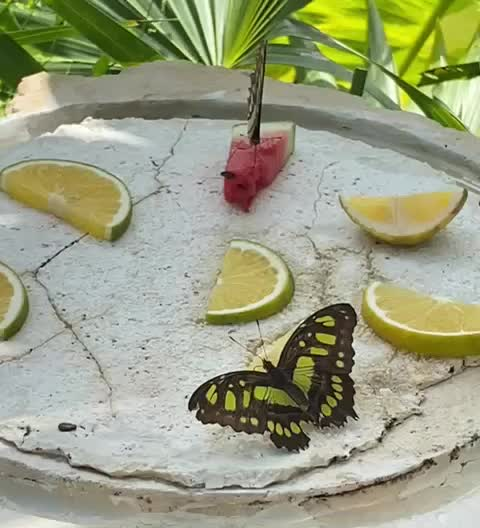

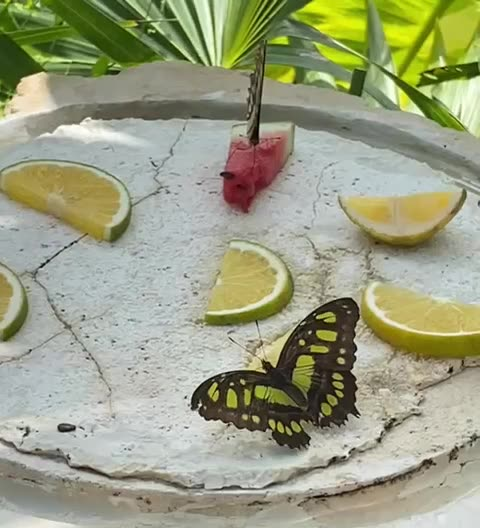

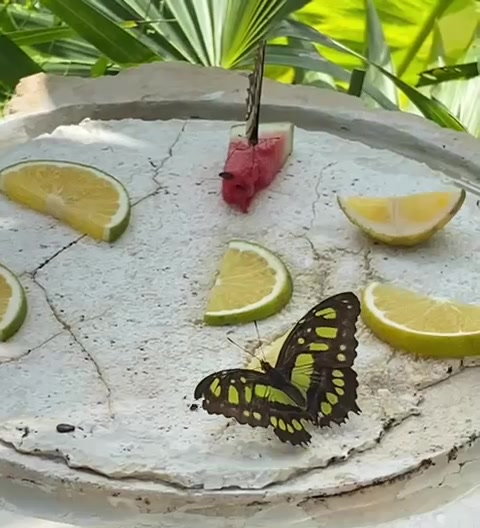

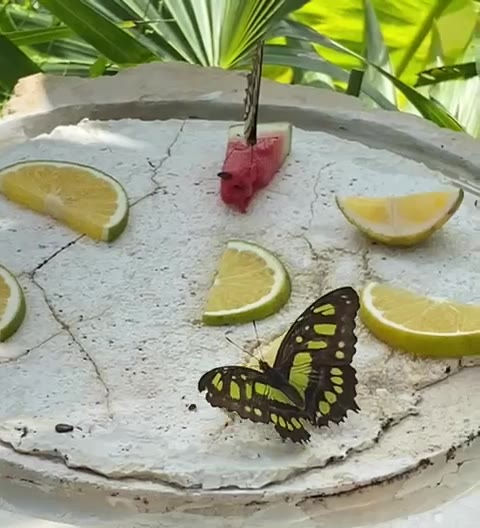

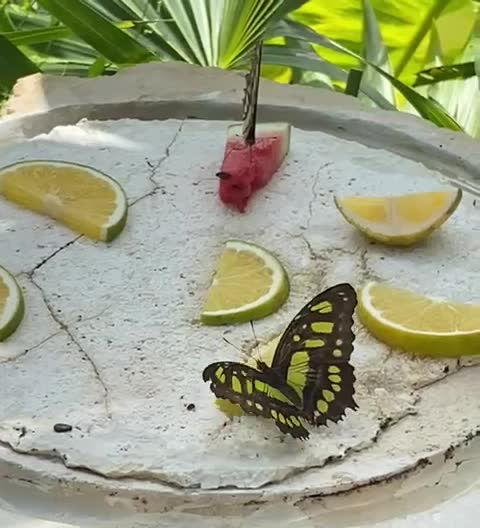

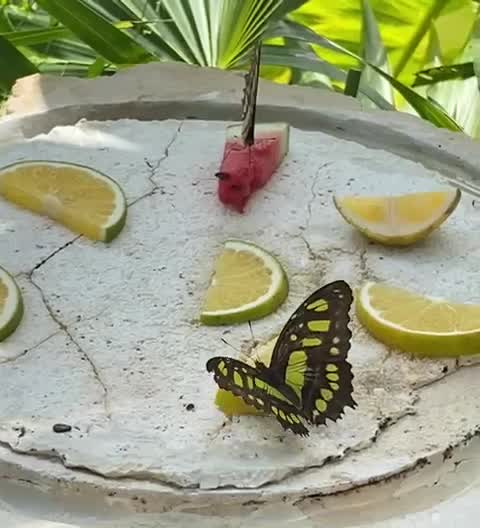

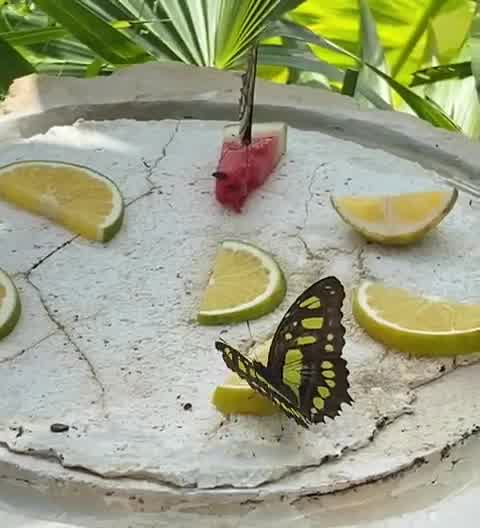

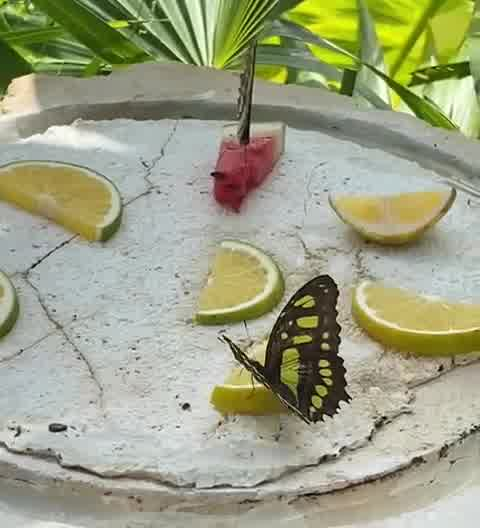

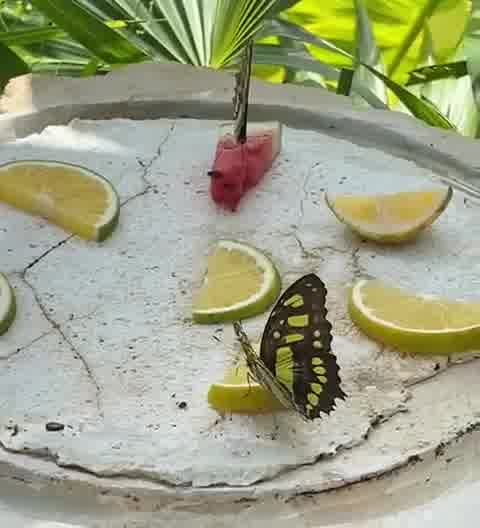

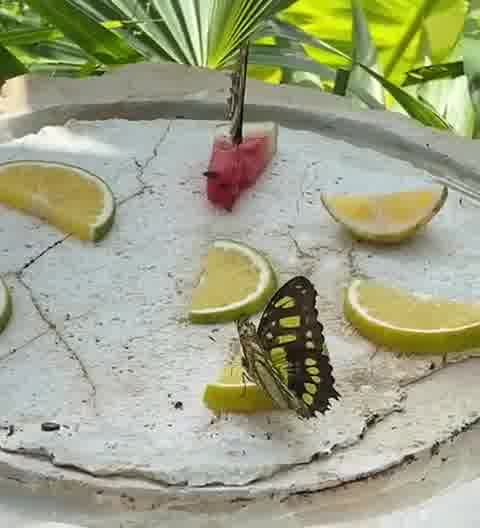

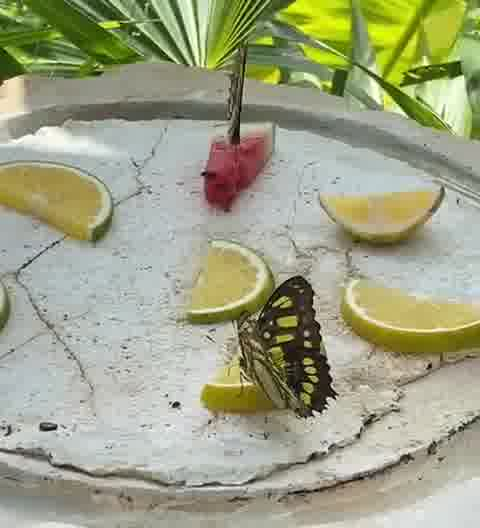

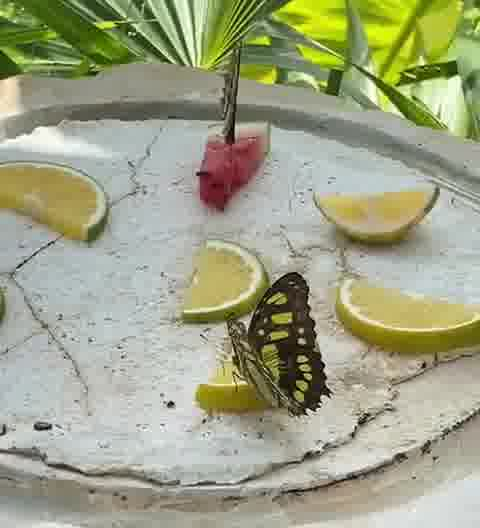

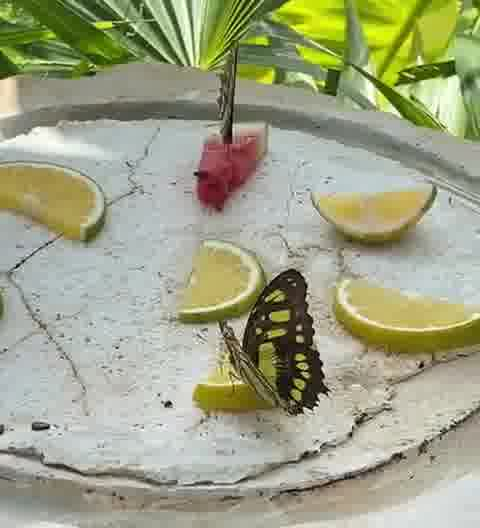

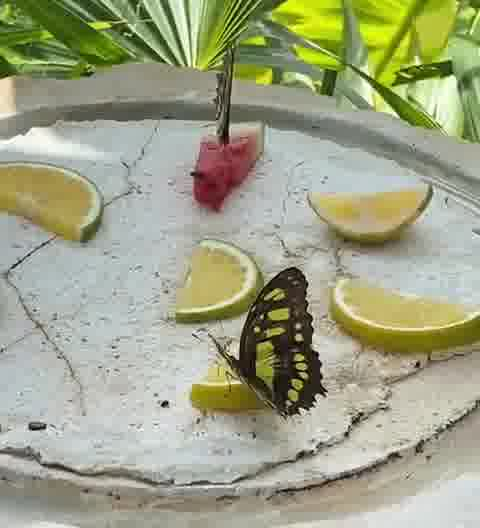

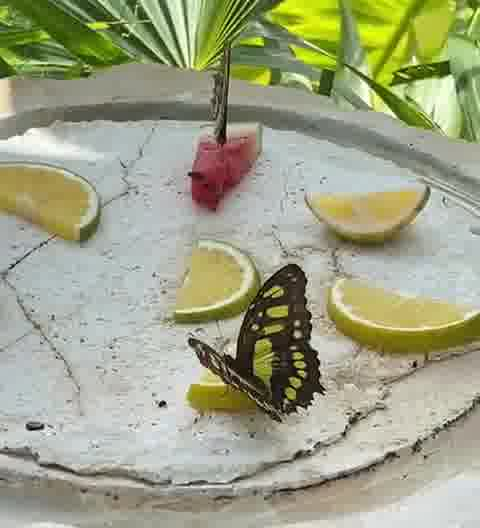

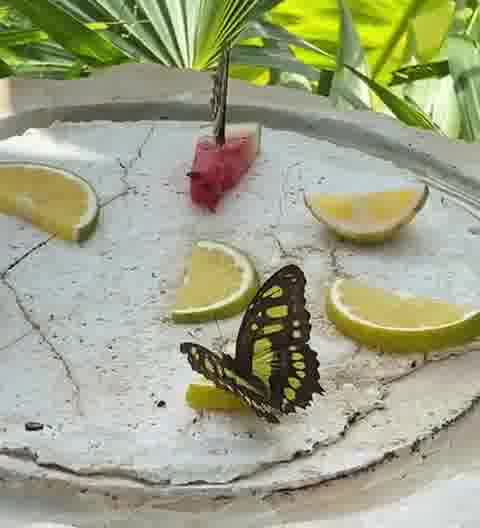

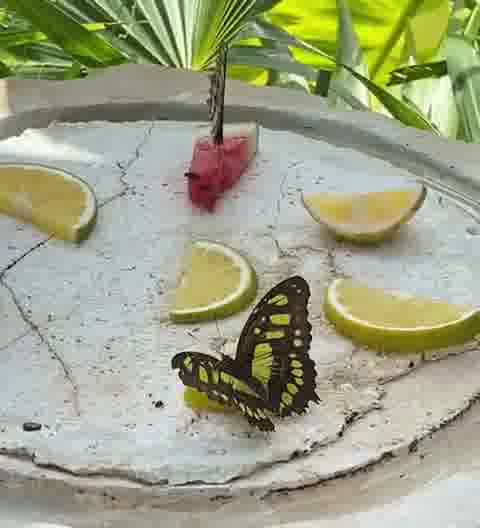

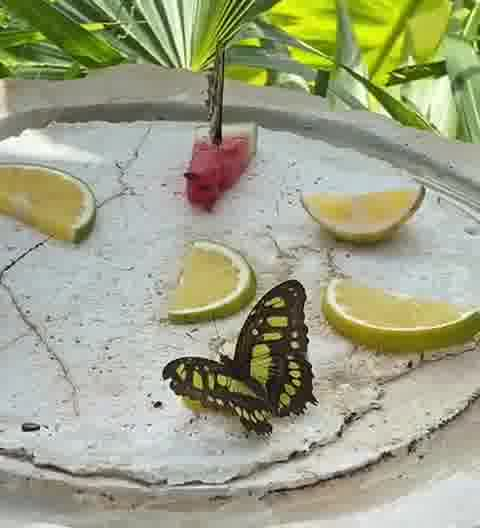

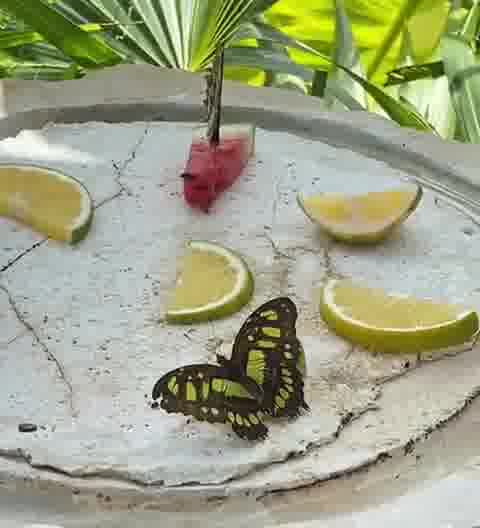

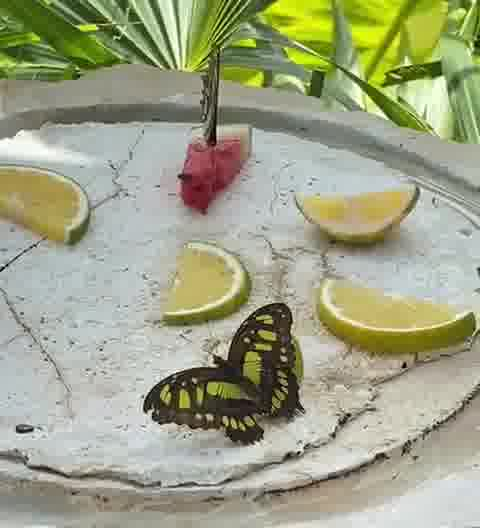

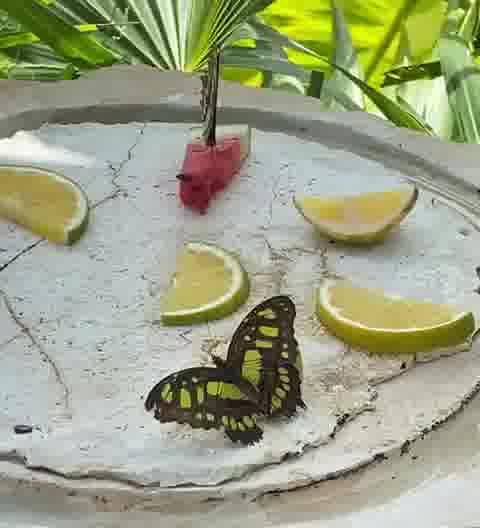

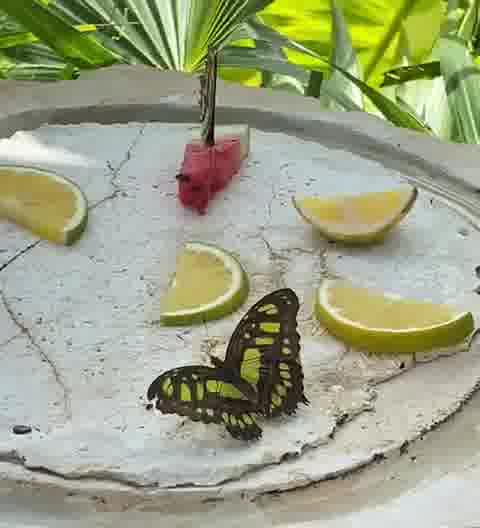

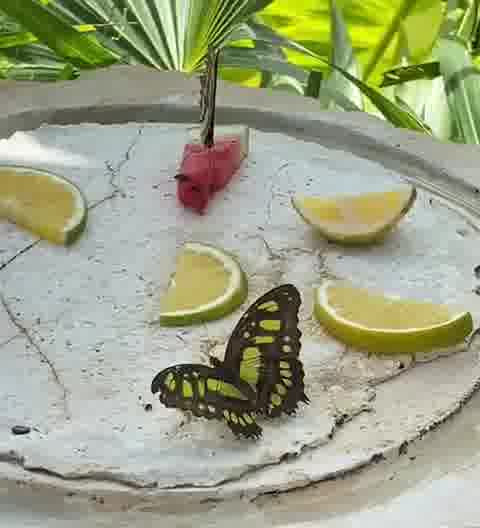

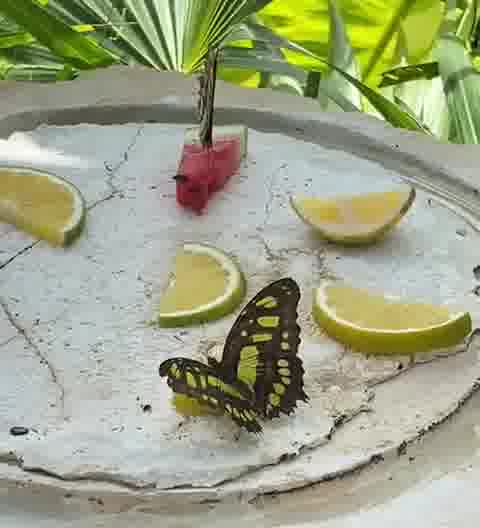

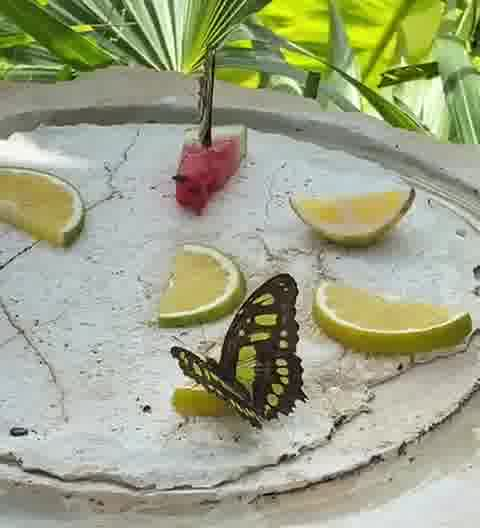

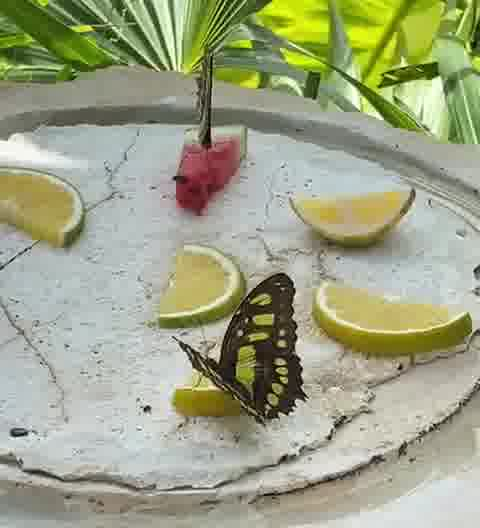

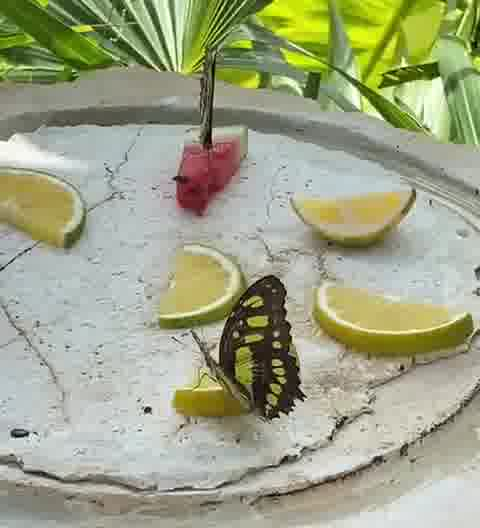

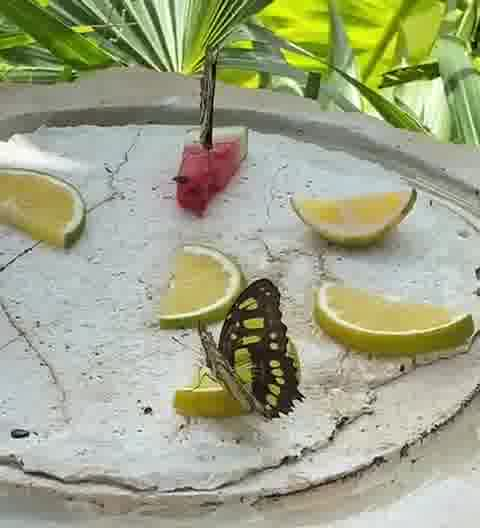

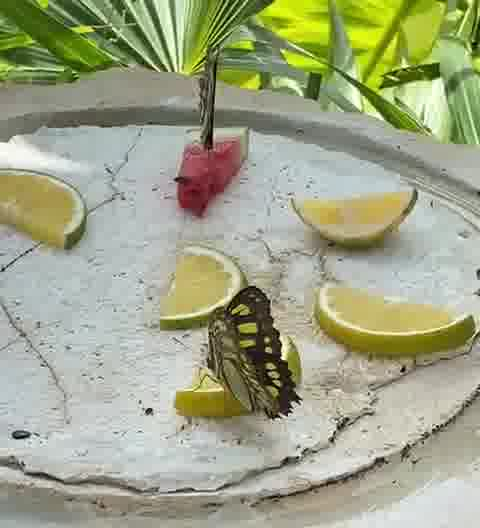

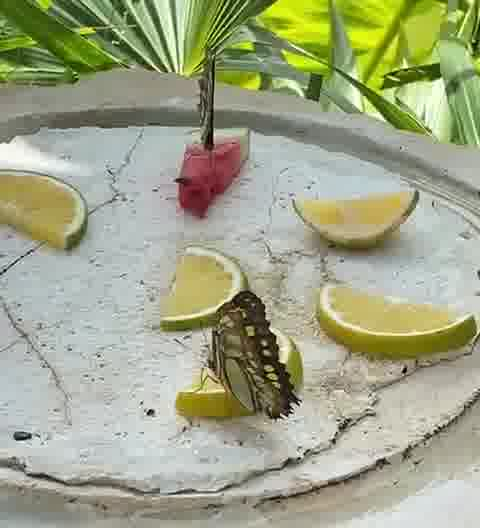

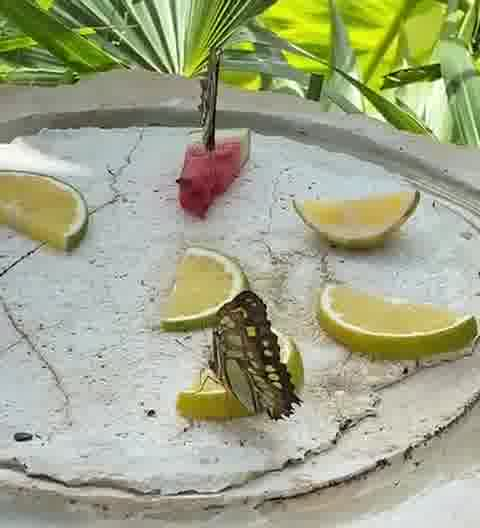

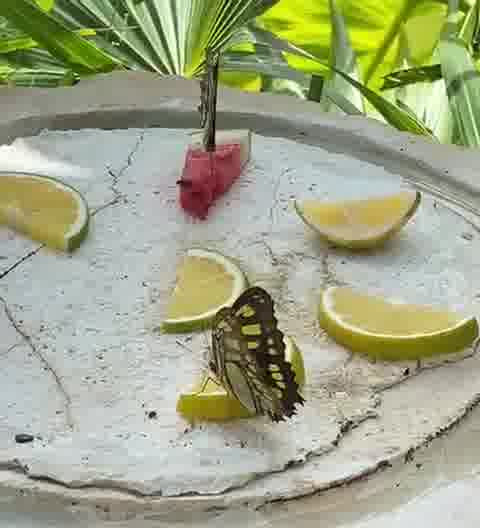

In [ ]:
import os
from IPython.display import Image, display

# Ruta al directorio donde se encuentran los frames
frames_directory = '/content/fotogramasmariposa/frames' #@param {type:"string"}
frames = [os.path.join(frames_directory, f) for f in os.listdir(frames_directory) if f.endswith('.jpg')]

# Ordena los frames por nombre, si es necesario
frames.sort()

# Visualiza los frames
for frame_path in frames:
    display(Image(filename=frame_path))

In [ ]:
# @title descarga un archivo Zip con los frames (ubica el directorio en donde se guardaron en colab)

from zipfile import ZipFile
import os
from google.colab import files

# Directorio donde se encuentran los frames
frames_directory = '/content/fotogramasmariposa/frames' # @param {type:"string"}

# Nombre del archivo ZIP que vamos a crear
zip_file_name = 'frames.zip'

# Crear el archivo ZIP y añadir los frames del directorio
with ZipFile(zip_file_name, 'w') as zip:
    for foldername, subfolders, filenames in os.walk(frames_directory):
        for filename in filenames:
            # Asegurarse de que solo se añadan archivos de imagen
            if filename.endswith('.jpg'):
                filePath = os.path.join(foldername, filename)
                # Añadir el archivo al ZIP
                zip.write(filePath, os.path.relpath(filePath, frames_directory))

# Descargar el archivo ZIP
files.download(zip_file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title subir y convertir los Fotogramas modificados
import os
from zipfile import ZipFile
from google.colab import files

# Subir el archivo .zip
uploaded = files.upload()
zip_file_name = next(iter(uploaded))

# Descomprimir el archivo .zip
output_dir = 'unzipped_frames'
os.makedirs(output_dir, exist_ok=True)

with ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(output_dir)


Saving framesn.zip to framesn (2).zip


In [ ]:
# @title Acomodar las imagenes todas de un mismo tamaño
from PIL import Image

def resize_images_to_match_first_image(frames_directory, target_size):
    for idx, frame_path in enumerate(os.listdir(frames_directory)):
        if frame_path.endswith('.jpg'):  # Asegurándose de que es una imagen
            with Image.open(os.path.join(frames_directory, frame_path)) as img:
                if idx == 0:
                    target_size = img.size  # Tamaño de la primera imagen
                else:
                    resized_img = img.resize(target_size, Image.ANTIALIAS)
                    resized_img.save(os.path.join(frames_directory, frame_path))

# Llama a la función antes de crear el ImageSequenceClip
frames = [os.path.join(frames_directory, f) for f in os.listdir(frames_directory) if f.endswith('.jpg')]
frames.sort()  # Ordena los frames por nombre

# Asegúrate de llamar a esta función antes de intentar crear el clip
resize_images_to_match_first_image(frames_directory, None)

# Ahora, intenta crear el clip nuevamente
clip = ImageSequenceClip(frames, fps=24)
clip.write_videofile(mp4_name, fps=24)


  resized_img = img.resize(target_size, Image.ANTIALIAS)



Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [ ]:
# @title Reproducir en a video y gif
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML
from base64 import b64encode

# Listar y ordenar los frames
frames_directory = output_dir
frames = [os.path.join(frames_directory, f) for f in os.listdir(frames_directory) if f.endswith('.jpg')]
frames.sort()

# Convertir a MP4
mp4_name = 'output.mp4'
clip = ImageSequenceClip(frames, fps=24)  # Ajuste del FPS a un valor más estándar
clip.write_videofile(mp4_name, fps=24)

# Visualizar el video en el cuaderno
mp4 = open(mp4_name, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display(HTML(f"""
<video width=400 controls loop autoplay>
    <source src="{data_url}" type="video/mp4">
</video>
"""))



Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
